# Importing Libraries

In [1]:
from IPython.display import Image

import pandas as pd
import numpy as np

# PDF Text extracttion
import tabula
import re

# Matching
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process

# Interactive visualisations
import os
import plotly.express as px
from plotly import graph_objects as go
import chart_studio
import chart_studio.plotly as py

In [2]:
data_one = pd.read_csv('flats_berlin_1.csv')
data_two = pd.read_csv('flats_berlin_2.csv')
data = data_one.append(data_two, sort=True).drop_duplicates(subset='Url')
data.reset_index(inplace=True, drop=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4056 entries, 0 to 4055
Data columns (total 29 columns):
Adreese                              4056 non-null object
Anbieter                             3520 non-null object
Ausstattung                          595 non-null object
Badezimmer                           2888 non-null float64
Balkon/ Terrasse                     791 non-null object
Baujahr                              3545 non-null object
Bezugsfrei ab                        1039 non-null object
Einbauküche                          1895 non-null object
Endenergiebedarf                     343 non-null object
Energieausweis                       2804 non-null object
Energieausweistyp                    2775 non-null object
Energieeffizienzklasse               330 non-null object
Energieverbrauchskennwert            468 non-null object
Etage                                3603 non-null object
Gesamtmiete                          4056 non-null object
Heizkosten                 

# Data Check

### Check for duplicated rows

In [4]:
pd.set_option('display.max_columns', 500)

In [5]:
data[data.duplicated()]

,Adreese,Anbieter,Ausstattung,Badezimmer,Balkon/ Terrasse,Baujahr,Bezugsfrei ab,Einbauküche,Endenergiebedarf,Energieausweis,Energieausweistyp,Energieeffizienzklasse,Energieverbrauchskennwert,Etage,Gesamtmiete,Heizkosten,Heizungsart,Kaltmiete,Kaution o. Genossenschaftsanteile,Modernisierung/ Sanierung,Nebenkosten,Objektzustand,Personenaufzug,Schlafzimmer,Titel,Url,Wesentliche Energieträger,Wohnfläche ca.,Zimmer


### Check percentage of missing values

In [6]:
data.isna().mean()

Adreese                              0.000000
Anbieter                             0.132150
Ausstattung                          0.853304
Badezimmer                           0.287968
Balkon/ Terrasse                     0.804980
Baujahr                              0.125986
Bezugsfrei ab                        0.743836
Einbauküche                          0.532791
Endenergiebedarf                     0.915434
Energieausweis                       0.308679
Energieausweistyp                    0.315828
Energieeffizienzklasse               0.918639
Energieverbrauchskennwert            0.884615
Etage                                0.111686
Gesamtmiete                          0.000000
Heizkosten                           0.000000
Heizungsart                          0.160750
Kaltmiete                            0.000000
Kaution o. Genossenschaftsanteile    0.072239
Modernisierung/ Sanierung            0.780079
Nebenkosten                          0.000000
Objektzustand                     

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4056 entries, 0 to 4055
Data columns (total 29 columns):
Adreese                              4056 non-null object
Anbieter                             3520 non-null object
Ausstattung                          595 non-null object
Badezimmer                           2888 non-null float64
Balkon/ Terrasse                     791 non-null object
Baujahr                              3545 non-null object
Bezugsfrei ab                        1039 non-null object
Einbauküche                          1895 non-null object
Endenergiebedarf                     343 non-null object
Energieausweis                       2804 non-null object
Energieausweistyp                    2775 non-null object
Energieeffizienzklasse               330 non-null object
Energieverbrauchskennwert            468 non-null object
Etage                                3603 non-null object
Gesamtmiete                          4056 non-null object
Heizkosten                 

# Data Transformation

Showcasing of different methods how data can be manipulated/cleaned up:

- str.replace
- .replace with regex
- loc selection and assignment
- custom functions
- lambda functions

In [8]:
data['Kaltmiete'] = pd.to_numeric(data['Kaltmiete'].str.replace('.','').str.replace(',','.').str.replace(' €',''))

In [9]:
data['Nebenkosten'] = data['Nebenkosten'].str.replace('.','').str.replace(',','.').str.replace(' €','')
data.loc[data['Nebenkosten'] == 'keine Angabe', 'Nebenkosten' ] = np.nan
data['Nebenkosten'] = pd.to_numeric(data['Nebenkosten'])

In [10]:
def transform_heizkosten(x):
    x = x.replace('.','').replace(',','.').replace(' €','')
    if x == 'in Nebenkosten enthalten' or 'inkl' in x:
        x = 0
    elif x == 'nicht in Nebenkosten enthalten' or x == 'keine Angabe':
        x = np.nan
    else:
        x
    return x

data['Heizkosten'] = pd.to_numeric(data['Heizkosten'].apply(transform_heizkosten))

In [11]:
data['Gesamtmiete'] = data['Gesamtmiete'].replace({r" €":"", r"\.":""},regex=True).replace({r"\,":"."},regex=True)
data['Gesamtmiete'] = pd.to_numeric(data['Gesamtmiete'].replace(to_replace=[r" \(zzgl Nebenkosten & Heizkosten\)",
                                                     r" \(zzgl Heizkosten\)",
                                                     r" \(zzgl Nebenkosten\)"],value='',regex=True))

In [12]:
data['Wohnfläche ca.'] = pd.to_numeric(
    data['Wohnfläche ca.'].apply(lambda string: string.replace(' m²','').replace('.','').replace(',','.')))

In [13]:
data['Kaution o. Genossenschaftsanteile'] = data['Kaution o. Genossenschaftsanteile'].replace(to_replace= [r" EUR",r" \€", r"\.",r"\€"],
                                                  value= '',
                                                  regex=True).replace().replace('\,','.',regex=True)

In [14]:
# To be further transformed if necessary
data['Kaution o. Genossenschaftsanteile'].sort_values(ascending=False).head()

2747    zwei Nettokaltmieten
1792                    nein
1323          nach Absprache
4027                      ja
4026                      ja
Name: Kaution o. Genossenschaftsanteile, dtype: object

In [15]:
data['Baujahr'] = pd.to_numeric(data['Baujahr'].replace("unbekannt",''))

In [16]:
data['Modernisierung/ Sanierung'] = pd.to_numeric(data['Modernisierung/ Sanierung'].replace(r"zuletzt ",'',regex=True))

In [17]:
data["Energieverbrauchskennwert"] = pd.to_numeric(data["Energieverbrauchskennwert"].replace(r" kWh/\(m\²\*a\)","",regex=True).replace(r"\.","",regex=True).replace(r"\,",".",regex=True))

In [18]:
# Correcting small spelling mistake
data.rename(columns={'Adreese':'Adresse'},inplace=True)

In [19]:
def split_address(x):
    address_list = x.split(',')
    length = len(address_list)
    street = np.nan
    zip_code = np.nan
    kiez = np.nan
    if length == 3:
        street = address_list[0].strip()
        zip_code = address_list[1].strip()
        kiez = address_list[2].strip()
        #return street, zip_code, kiez
    if length == 2:
        street = np.nan
        zip_code = address_list[0].strip()
        kiez = address_list[1].strip()
        kiez = kiez.replace(' Die vollständige Adresse der Immobilie erhalten Sie vom Anbieter.','').strip()
    
    return street, zip_code, kiez

address = pd.DataFrame.from_records(data['Adresse'].apply(split_address)).rename(columns={0:'Straße',1:'PLZ',2:'Kiez'})
data = data.join(address)

In [20]:
def split_street_house_number(string):
    street = np.nan
    number = np.nan
    
    if isinstance(string, str):
        match = re.search('\d{1,5}\s?\w*',string)
        if match:
            street = string[:match.span()[0]].strip()
            street = street.replace('Str.','Straße').replace('str.','straße')
            number = string[match.span()[0]:match.span()[1]].strip().replace(' ','')
    
    return pd.Series({'Straße':street, 'Housenumber':number})

In [21]:
data[['Straße','Hausnummer']] = data['Straße'].apply(split_street_house_number)

In [22]:
data['Hausnummer'] = data['Hausnummer'].str.upper()

In [23]:
data['Bezirk'] = data['Kiez'].str.split('(',expand=True)[0].str.strip(')').str.strip()

In [24]:
data['Ortsteil'] = data['Kiez'].str.split('(',expand=True)[1].str.strip(')').str.strip()

In [25]:
data.drop(columns = 'Kiez',inplace=True)

In [26]:
data['Straße'].isnull().mean()

0.15212031558185404

## Feature Engineering

In [27]:
data['Kaltmiete pro m²'] = data['Kaltmiete']/data['Wohnfläche ca.']

## Location Rating

PDF Source: https://www.stadtentwicklung.berlin.de/wohnen/mietspiegel/de/download/Strassenverzeichnis2019.pdf

### PDF Extraction with tabula (Part 1: Bezrik, Ortsteil)

In [28]:
# Extracting main street information left tables
top = 120
left = 44
height = 666
width = 164

y1 = top
x1 = left
y2 = top + height
x2 = left + width

area=(y1,x1,y2,x2)
columns = [44,73,164]

abbrevations_one = tabula.read_pdf("Strassenverzeichnis2019.pdf", 
                     pages='2', 
                     area=area,
                     columns=columns,
                     pandas_options={'columns':['Unnamed: 0','Bezirk','Ortsteil','Ortsteil Abkürzung']},
                     guess=False)[0]

top = 120
left = 216
height = 666
width = 164

y1 = top
x1 = left
y2 = top + height
x2 = left + width

area=(y1,x1,y2,x2)
columns = [216,245,336]

abbrevations_two = tabula.read_pdf("Strassenverzeichnis2019.pdf", 
                     pages='2', 
                     area=area,
                     columns=columns,
                     pandas_options={'columns':['Unnamed: 0','Bezirk','Ortsteil','Ortsteil Abkürzung']},
                     guess=False)[0]

top = 120
left = 388
height = 6666
width = 164

y1 = top
x1 = left
y2 = top + height
x2 = left + width

area=(y1,x1,y2,x2)
columns = [388,418,509]

abbrevations_three = tabula.read_pdf("Strassenverzeichnis2019.pdf", 
                     pages='2', 
                     area=area,
                     columns=columns,
                     pandas_options={'columns':['Unnamed: 0','Bezirk','Ortsteil','Ortsteil Abkürzung']},
                     guess=False)[0]

In [29]:
abbreviations = abbrevations_one.append(abbrevations_two).append(abbrevations_three).drop(columns='Unnamed: 0')

#File was exported and quickly cleaned with GSheets
abbreviations.to_csv('to_be_cleaned_abreviations.csv')

In [30]:
# After quick cleaning with GSheets reading in data again
abbreviations = pd.read_csv('cleaned_abreviations.csv')
abbreviations.drop_duplicates(subset='Ortsteil',keep='last',inplace=True)
abbreviations.rename(columns={'Bezirk':'Bezirk Abkürzung'},inplace=True)

# Adjust one Ortsteil with other naming convention
data.loc[data['Ortsteil'] == 'Treptow', 'Ortsteil' ] = 'Alt-Treptow'

# Add Ortsteil info to existing data
data = pd.merge(data, abbreviations, on='Ortsteil', how='left')

# Drop records where no Ortsteil could be matched
data.dropna(subset=['Ortsteil'],inplace=True)

### PDF Extraction with tabula (Part 2: Location quality)

In [31]:
# Extracting left tables
top = 69
left = 39
height = 723
width = 253

y1 = top
x1 = left
y2 = top + height
x2 = left + width

area=(y1,x1,y2,x2)
columns = [39,164.23,186.03,193.35,244.96,256.63,286.21]

dfs_1 = tabula.read_pdf("Strassenverzeichnis2019.pdf", 
                     pages='3-262', 
                     area=area,
                     columns=columns,
                     pandas_options={'columns':['Unnamed: 0',
                                                'Straße',
                                                'Bezirk Abkürzung',
                                                'Gebietsstand',
                                                'Hausnummer',
                                                'Buchstabe',
                                               'Wohnlage Einstufung',
                                               'Lage im Stadtgebiet']},
                     guess=False)

# Extracting right tables
top = 69
left = 303
height = 723
width = 253

y1 = top
x1 = left
y2 = top + height
x2 = left + width

area=(y1,x1,y2,x2)
columns = [303,428, 450, 457,509, 520,550]

dfs_2 = tabula.read_pdf("Strassenverzeichnis2019.pdf", 
                     pages='3-262', 
                     area=area,
                     columns=columns,
                     pandas_options={'columns':['Unnamed: 0',
                                                'Straße',
                                                'Bezirk Abkürzung',
                                                'Gebietsstand',
                                                'Hausnummer',
                                                'Buchstabe',
                                               'Wohnlage Einstufung',
                                               'Lage im Stadtgebiet']},
                     guess=False)

dfs_1.append(dfs_2)

In [32]:
# Create new empty final dataframe
location_info = pd.DataFrame()
tables = dfs_1
for table in tables:
    location_info = location_info.append(table)
    
location_info.drop(columns='Unnamed: 0',inplace=True)

# Filter out letters, e.g. A, B ...
location_info = location_info[location_info['Straße'].apply(lambda x: len(x)) != 1]

location_info['Ortsteil Abkürzung'] = location_info['Straße'].str.split('(',expand=True)[1].str.strip(')').str.strip('')
location_info['Straße'] = location_info['Straße'].str.split('(',expand=True)[0].str.strip('')

location_info = location_info.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [33]:
def transform_housenumbers(df):
    if isinstance(df['Hausnummer'], str):
        # Split house numbers into start and end
        start = df['Hausnummer'].split('-')[0].strip()
        end = df['Hausnummer'].split('-')[1].strip()
        
        # Check for letters e.g. 5A 
        start_letter = re.search('[A-Z]', start)
        end_letter = re.search('[A-Z]', end)
        
        # Find actual start and ending housenumber
        start = int(re.search('\d*', start).group())
        end = int(re.search('\d*', end).group())
        
        # Continuing streets, e.g. 1, 2, 3, 4, 5
        if df['Buchstabe'] == 'F':
            house_number_list = list(range(start,end+1))
        
        # Even or uneven streets, e.g. 1, 3, 5 or 2, 4, 6
        elif df['Buchstabe'] == 'G' or df['Buchstabe'] == 'U':
            house_number_list = list(range(start,end+1,2))
        
        house_number_list = [str(e) for e in house_number_list]
        if start_letter:
            start_letter = start_letter.group().strip()
            house_number_list[0] += start_letter
        elif end_letter:
            end_letter = end_letter.group().strip()
            house_number_list[-1] += end_letter
        return house_number_list
    else:
        return df['Hausnummer'] 

location_info['Hausnummer'] = location_info.apply(transform_housenumbers, axis=1)

location_info = location_info.reset_index().explode('Hausnummer')

## Merging Location Rating features to Scraped Data

In [34]:
# Percentage of data without an address which means we cannot assess location quality
data['Adresse'].apply(lambda x: True if 'Die vollständige Adresse der Immobilie erhalten Sie vom Anbieter.' in x else False).mean()

0.14752475247524752

In [35]:
def match_street(x):
    if isinstance(x, str):
        match = process.extractOne(x, list(location_info['Straße'].unique()))
        if match[1] > 90:
            return match[0]
        else:
            return x
    else:
        return x
    
#Computationally quite expensive (only do this once if you have new data)
%time data['Straße'] = data['Straße'].apply(match_street)

#Results temporarily saved to iterate over data faster
data.to_csv('temp_data.csv',index=False)

CPU times: user 19min 46s, sys: 6.11 s, total: 19min 52s
Wall time: 20min 1s


In [36]:
# Optionally saved df to iterate over problems much faster
data = pd.read_csv('temp_data.csv')

In [37]:
# Strip one more time all strings of whitespace to guarantee correct merge
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
location_info = location_info.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# First merge attempt on three criterias
matching_one = pd.merge(data, location_info,on=['Straße','Bezirk Abkürzung','Hausnummer'],how='left')

# Percentage of data for which we could add location rating
matching_one.dropna(subset=['Url'])['Wohnlage Einstufung'].notnull().mean()

0.6029698149951315

In [38]:
# In the pdf there are location info for entire streets (marked with letter K), allowing us not to merge with the exact housenumber
matching_two = pd.merge(data, location_info[location_info['Buchstabe'] == 'K'], on=['Straße','Bezirk Abkürzung'], how='left')

# Drop duplicated columns
matching_two = matching_two.drop(columns='Hausnummer_y').rename(columns={'Hausnummer_x':'Hausnummer'})

# Percentage of data for which we could add location rating
matching_two.dropna(subset=['Url'])['Wohnlage Einstufung'].notnull().mean()

0.12756489493201484

In [39]:
# Combine both merges from above to create final_data_frame
matching = matching_one.append(matching_two)

# Drop all records for which we could not find a location rating
matching.dropna(subset=['Wohnlage Einstufung'], inplace=True)

# Some streets are so common that they are duplicate, resulting in duplicated values
# In the PDF only those streets had a location abbreviation. I filter out now those records to add them later back in the df
matching_three = matching[matching['Ortsteil Abkürzung_x'] == matching['Ortsteil Abkürzung_y']]

# Get rid of all duplicated records in the file
matching.drop_duplicates(subset=['Url'], keep=False, inplace=True)

# Add back the records which had many streets with the same name
matching = matching.append(matching_three)

# Get rid of all duplicated records in the file once more
matching.drop_duplicates(subset='Url',inplace=True)

matching.reset_index(inplace=True, drop=True)

matching.drop(columns='Ortsteil Abkürzung_y',inplace=True)
matching.rename(columns={'Ortsteil Abkürzung_x': 'Ortsteil Abkürzung'},inplace=True)

## Calculation of Rental Price Ceiling

The main infromation for the calculation can be found here: https://stadtentwicklung.berlin.de/wohnen/wohnraum/mietendeckel/

### 1) Base Table (year of building, bathroom, central heating)
The following base table takes the year the building was built, central heating and the existance of a bathroom to come up with a base price.

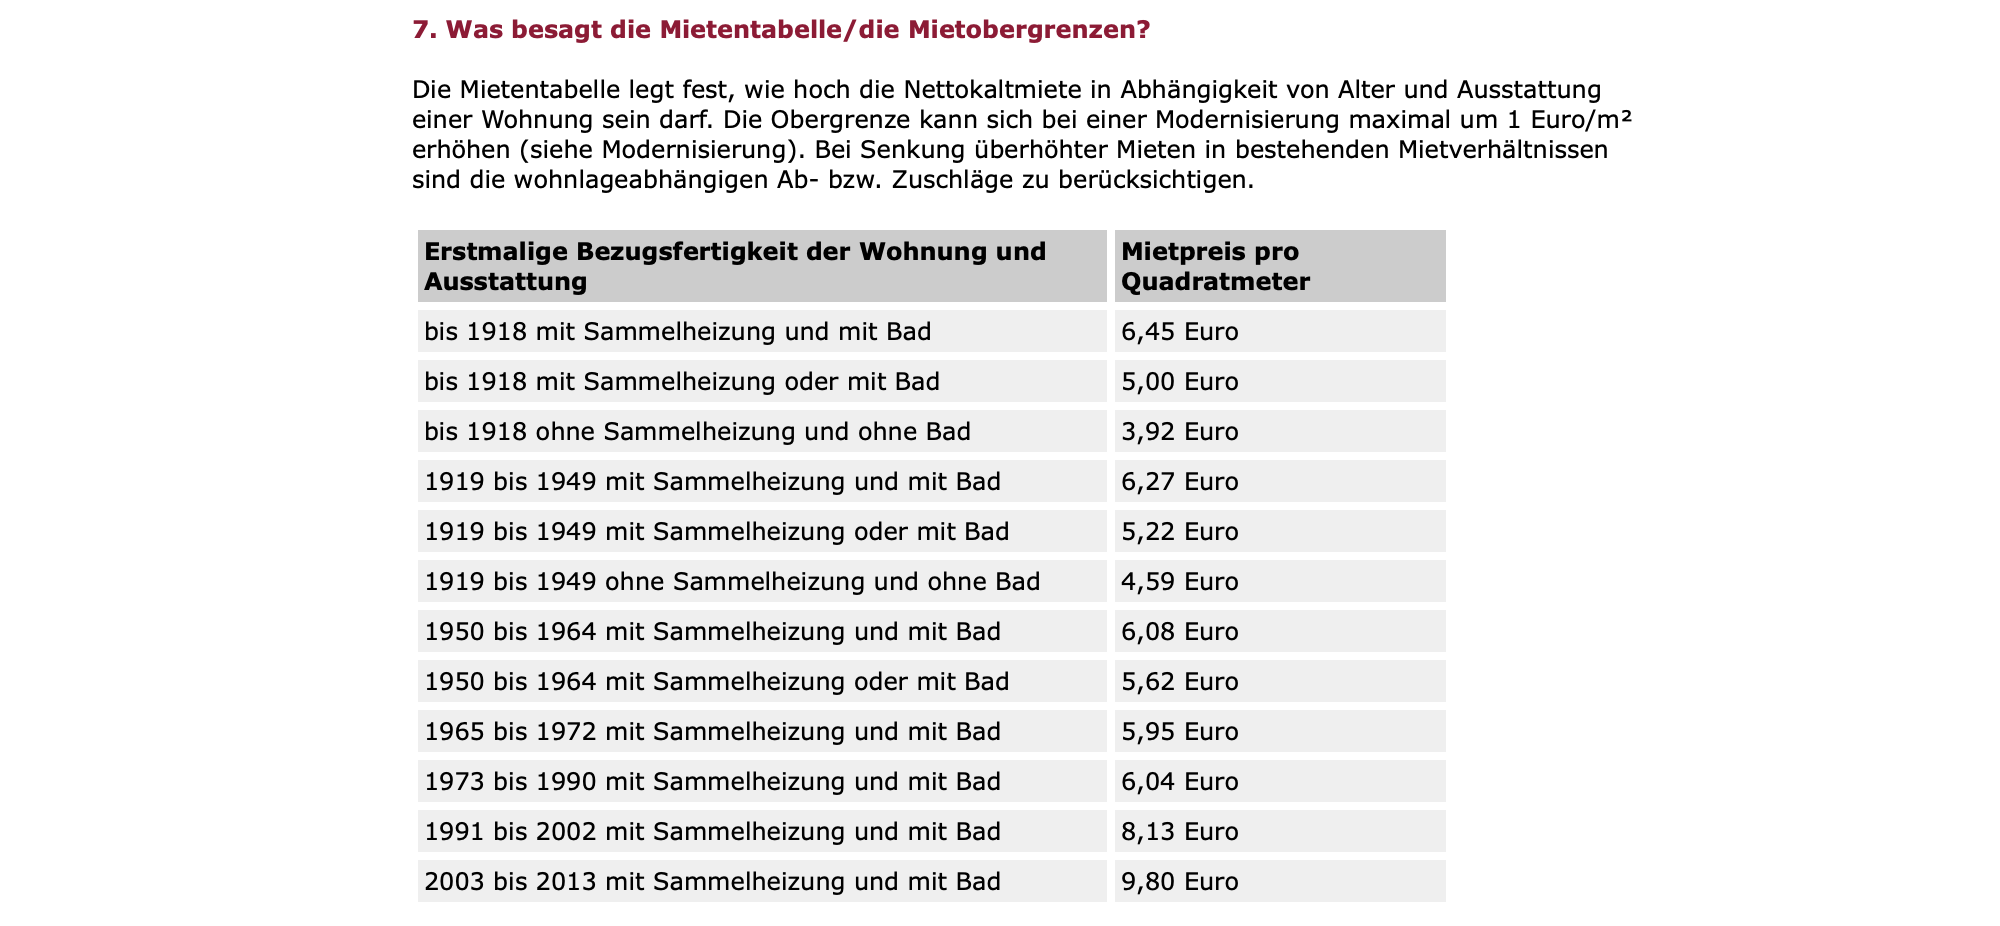

In [40]:
Image("img/mietentabelle.png")

#### English Translation

In [41]:
rental_ceiling_info = {
    'min_year': [1918, 1918, 1918, 1919, 1919, 1919, 1950, 1950, 1965, 1973, 1991, 2003 ],
    'max_year': [1918, 1918, 1918, 1949, 1949, 1949, 1964, 1964, 1972, 1990, 2002, 2013 ],
    'central_heating' : [True, True, False, True, True, False, True, True, True, True, True, True],
    'condition': ['and', 'or', 'and', 'and', 'or', 'and', 'and', 'or', 'and', 'and', 'and', 'and'],
    'bathroom' : [True, True, False, True, True, False, True, True, True, True, True, True],
    'price_per_square_meter' : [6.45, 5.00, 3.92, 6.27, 5.22, 4.59, 6.08, 5.62, 5.95, 6.04, 8.13, 9.8]
}

rental_ceiling_info = pd.DataFrame.from_dict(rental_ceiling_info)
rental_ceiling_info

,min_year,max_year,central_heating,condition,bathroom,price_per_square_meter
0,1918,1918,True,and,True,6.45
1,1918,1918,True,or,True,5.00
2,1918,1918,False,and,False,3.92
3,1919,1949,True,and,True,6.27
4,1919,1949,True,or,True,5.22
5,1919,1949,False,and,False,4.59
6,1950,1964,True,and,True,6.08
7,1950,1964,True,or,True,5.62
8,1965,1972,True,and,True,5.95
9,1973,1990,True,and,True,6.04


## 2) Modern equipment

Furthermore if at least three of the following criteria are met, one euro is added to the cold rent per squaremeter to adjust for modern equipment:

*Für Wohnungen mit moderner Ausstattung erhöht sich der Wert um 1,00 Euro. Eine moderne Ausstattung liegt vor, wenn mindestens drei der folgenden Merkmale vorhanden sind:* 

- *schwellenlos erreichbarer Aufzug,*
- *Einbauküche,*
- *hochwertige Sanitärausstattung,*
- *hochwertiger Bodenbelag in der überwiegenden Zahl der Wohnräume,*
- *Energieverbrauchskennwert von weniger als 120 kWh/(m² a)*



## 3) Location Rating

Next there is an additional premium or dedcution based on the location of the flat. The exact location criteria are not published yet but the PDF above gives the best potential idea of the to be published location rating:

*Für Wohnungen in einfacher Wohnlage ist bei der Berechnung der Mietobergrenze ein Abschlag beim maßgeblichen Mietpreis in der Mietentabelle von 0,28 Euro zu berücksichtigen, für Wohnungen in mittlerer Wohnlage werden 0,09 Euro abgezogen und für Wohnungen in guter Wohnlage ist ein Zuschlag von 0,74 Euro zu berücksichtigen. (Die Lageeinordnung wird demnächst veröffentlicht.)*

## 4) Single or double family house

Since I scraped only flats this criteria can be negelected and I will not need to take into consideration an additional increase of 10% to the price.

*9. Was ist mit Ein- und Zweifamilienhäusern? Auch für sie gilt das Gesetz. Liegt der Wohnraum in Gebäuden mit nicht mehr als zwei Wohnungen, erhöht sich jedoch die Mietobergrenze um einen Zuschlag von zehn Prozent.*

## Assumptions

With the mentioned criteria above, I took the following conservative assumptions to calculate the price rental ceiling per square meter:

- maximum price from the base table (1) for the respective year of construction, which means that it is assumed that all the flats have central heating and a bath room
- all the flats fufill at least three criteria, meaning that it is assumed that they all have modern equipment
- the rent index PDF document published in 2019 is a good approximation for the location rating (2)
- all the flats are non single family houses (scraped data only for apartments)

## Calculation

max_price_per_square_meter = (base_price + location factor + modern_equipment_factor) * (1 + 20%)

### Max rental price ceiling

In [42]:
def find_base_price(df):
    """Takes in a dataframe and finds base price for the year the building was built.
    
    Args:
    - df: Dataframe
    
    Returns:
    - column (float): base price for the respective year the house was built
    
    """
    # Initialising criteria
    
    location_factor, base_price = (np.nan, np.nan)
    
    # Age of the building
    if df['Baujahr'] <= 1918:
        base_price = 6.45
    elif df['Baujahr'] >= 1919 and df['Baujahr'] <= 1949:
        base_price = 6.27
    elif df['Baujahr'] >= 1950 and df['Baujahr'] <= 1964:
        base_price = 6.08
    elif df['Baujahr'] >= 1965 and df['Baujahr'] <= 1972:
        base_price = 5.95
    elif df['Baujahr'] >= 1973 and df['Baujahr'] <= 1990:
        base_price = 6.04
    elif df['Baujahr'] >= 1991 and df['Baujahr'] <= 2002:
        base_price = 8.13
    elif df['Baujahr'] >= 2003 and df['Baujahr'] <= 2013:
        base_price = 9.80
    
    return base_price

In [43]:
def find_location_factor(df):
    """Takes in a dataframe and finds the location factor
    
    Args:
    - df: Dataframe
    
    Returns:
    - column (float): location factor depending on the quality of the location
    
    """
    
    # Location factor of the flat
    if df['Wohnlage Einstufung'].strip(' *') == 'einfach':
        location_factor = -0.28
    elif df['Wohnlage Einstufung'].strip(' *') == 'mittel':
        location_factor = -0.09
    elif df['Wohnlage Einstufung'].strip(' *') == 'gut':
        location_factor = 0.74
    
    return location_factor

In [44]:
base_price = matching.apply(find_base_price, axis=1)
location_factor = matching.apply(find_location_factor, axis=1)


# Modern equipment factor of the flat
modern_equipment_factor = 1

# Maximum overpricing
percent = 0.2
    
max_price_per_square_meter = (base_price + location_factor + modern_equipment_factor) * (1+percent)

matching['Zulässige Mietobergrenze pro m²'] = max_price_per_square_meter

# Data Analysis

In [325]:
illegal_pricing = matching[matching['Kaltmiete pro m²'] > matching['Zulässige Mietobergrenze pro m²']]
legal_pricing = matching[matching['Kaltmiete pro m²'] < matching['Zulässige Mietobergrenze pro m²']]

In [56]:
username = os.getenv('PLOTLY_USERNAME')
api_key = os.getenv('PLOTLY_API_KEY') # your api key - go to profile > settings > regenerate key

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [326]:
fig = go.Figure(go.Funnel(
    y = ['All Scraped Listings', 'Listings with sufficient Information', 'Listings over rental cap'],
    x = [len(data),len(legal_pricing) + len(illegal_pricing),len(illegal_pricing)],
    text = ["All","Sufficient Info", "Overpriced"],
    opacity = 0.65, 
    marker = {"color": ["silver", "green", "red"]}
    ))

fig.update_layout(
    title="Overview of Analysed Listings")

fig.show()

In [ ]:
py.plot(fig, filename = 'funnel_listings', auto_open=True)

### Average price before and after the law

In [58]:
matching['Kaltmiete pro m²'].mean()

15.116483831008976

In [59]:
matching['Zulässige Mietobergrenze pro m²'].mean()

9.209192649673984

In [60]:
(matching['Kaltmiete pro m²'].mean() - matching['Zulässige Mietobergrenze pro m²'].mean())/ matching['Kaltmiete pro m²'].mean()

0.3907847385261087

### Pricing differenct between districts

In [61]:
average_rent_difference_per_district = matching.groupby('Ortsteil')[['Kaltmiete pro m²','Zulässige Mietobergrenze pro m²']].mean().stack().reset_index()

average_rent_difference_per_district.rename(columns={
   'level_1':'Comparison', 0 :'Average Rent' 
}, inplace=True)

In [62]:
fig = px.bar(average_rent_difference_per_district, 
             x='Ortsteil', 
             y='Average Rent',
             color='Comparison',
             barmode='group',
             title='Comparison of Current and Newly Caculated Rent Cap per District')
fig.show()

In [ ]:
py.plot(fig, filename = 'average_rent_difference_per_district', auto_open=True)

In [63]:
percentage_rent_difference_per_district = matching.groupby('Ortsteil')[['Kaltmiete pro m²','Zulässige Mietobergrenze pro m²']].mean()

percentage_rent_difference_per_district = pd.DataFrame((percentage_rent_difference_per_district['Kaltmiete pro m²'] - percentage_rent_difference_per_district['Zulässige Mietobergrenze pro m²']) / percentage_rent_difference_per_district['Kaltmiete pro m²']*100)

percentage_rent_difference_per_district = percentage_rent_difference_per_district.rename(columns={0:'Percentage Change in Average Price'}).reset_index()

percentage_rent_difference_per_district = percentage_rent_difference_per_district.sort_values(['Percentage Change in Average Price'],ascending=False)

In [64]:
fig = px.bar(percentage_rent_difference_per_district, 
             x='Ortsteil', 
             y='Percentage Change in Average Price',
             title='Comparison of Price Change per District')
fig.show()

In [ ]:
py.plot(fig, filename = 'percentage_rent_difference_per_district', auto_open=True)

## Exccess Rent paid

In [295]:
# Excess amount paid per month
illegal_cold_rent = illegal_pricing['Kaltmiete pro m²'] * illegal_pricing['Wohnfläche ca.']
illegal_rent_cap = illegal_pricing['Zulässige Mietobergrenze pro m²'] * illegal_pricing['Wohnfläche ca.']
illegal_excess_rent = illegal_cold_rent.sum() - illegal_rent_cap.sum()

In [296]:
illegal_excess_rent

463059.78743999975

In [66]:
illegal_pricing[['Titel', 'Anbieter' ,'Url', 'Adresse', 'Baujahr', 'Wohnlage Einstufung', 'Wohnfläche ca.', 'Kaltmiete', 'Kaltmiete pro m²', 'Zulässige Mietobergrenze pro m²']]

,Titel,Anbieter,Url,Adresse,Baujahr,Wohnlage Einstufung,Wohnfläche ca.,Kaltmiete,Kaltmiete pro m²,Zulässige Mietobergrenze pro m²
0,Nutzen Sie Ihre Chance - 2 Zimmerwohnung mit b...,German Prop Tech GmbH,https://www.immobilienscout24.de/expose/114414026,"Reinickendorfer Straße 4, 13447 Berlin, Weddin...",1972.0,einfach *,78.00,979.4,12.556410,8.004
2,Lichtdurchflutetes Appartement - Tageslichtbad...,Stadthaus Verwaltungsgesellschaft mbH Franklin...,https://www.immobilienscout24.de/expose/100591334,"Schulenburgring 125, 12101 Berlin, Tempelhof (...",1956.0,mittel,38.48,503.0,13.071726,8.388
3,Eine Perle mit modernem Grundriss,wfi- Wohlfühlimmobilien Thomas- Müntzer- Damm ...,https://www.immobilienscout24.de/expose/115502827,"Richard- Sorge- Straße 10, 10249 Berlin, Fried...",2010.0,gut,91.89,1290.0,14.038524,13.848
4,Hochwertiges DG im gepflegten Altbau! **Besich...,SchönLife Immobilien Wielandstraße 12 10629 Be...,https://www.immobilienscout24.de/expose/115172918,"Cauerstrasse 25, 10587 Berlin, Charlottenburg ...",1905.0,mittel *,119.00,1785.0,15.000000,8.832
6,Praktische Familienwohnung mit Laminat - in He...,Immonexxt GmbH Am Borsigturm 53 13507 Berlin,https://www.immobilienscout24.de/expose/114889465,"Kastanienallee 86, 12627 Berlin, Hellersdorf (...",1985.0,mittel,68.54,639.0,9.323023,8.340
...,...,...,...,...,...,...,...,...,...,...
2834,NEUBAU ERSTBEZUG 200 m² - Exklusive Dachgescho...,Massih-Hausverwaltung Knesebeckstraße 55 10719...,https://www.immobilienscout24.de/expose/115805257,"Eisenacher Str. 64, 10823 Berlin, Schöneberg (...",1900.0,mittel,200.00,3400.0,17.000000,8.832
2836,"Möblierte 1 Zimmer Studio in Berlin, Schöneber...",NaN,https://www.immobilienscout24.de/expose/108875055,"Goltzstraße 39, 10781 Berlin, Schöneberg (Schö...",1908.0,gut,45.00,950.0,21.111111,9.828
2841,Toller Altbau in begehrter Lage- Anfragen bitt...,Andrej Schafranek Immobilien,https://www.immobilienscout24.de/expose/115773874,"Buchholzer Str. 4, 10437 Berlin, Prenzlauer Be...",1900.0,gut,94.61,1199.0,12.673079,9.828
2842,Helle 2 Zimmer Wohnung! Ihr neues zu Hause in ...,ALEPA Real Estate GmbH Tauentzienstraße 6 1078...,https://www.immobilienscout24.de/expose/115760600,"Mühlenstraße 30, 13187 Berlin, Pankow (Pankow)",1910.0,mittel *,73.00,799.0,10.945205,8.832


In [67]:
top_10_illegal_real_estate_comp = illegal_pricing.groupby('Anbieter')[['Url']].count().sort_values(by='Url',ascending=False).head(10)

average_illegal_current_rent = illegal_pricing[illegal_pricing['Anbieter'].isin(top_10_illegal_real_estate_comp.index)].groupby('Anbieter')[['Kaltmiete pro m²']].mean()

average_illegal_rent_cap = illegal_pricing[illegal_pricing['Anbieter'].isin(top_10_illegal_real_estate_comp.index)].groupby('Anbieter')[['Zulässige Mietobergrenze pro m²']].mean()

top_10_illegal_real_estate_comp = top_10_illegal_real_estate_comp.join(average_illegal_current_rent).join(average_illegal_rent_cap)

top_10_illegal_real_estate_comp['Average excess rent'] = top_10_illegal_real_estate_comp['Kaltmiete pro m²'] - top_10_illegal_real_estate_comp['Zulässige Mietobergrenze pro m²']

top_10_illegal_real_estate_comp.rename(columns = {'Zulässige Mietobergrenze pro m²':'Rent cap'}, inplace=True)

In [68]:
top_10_illegal_real_estate_comp.sort_values('Average excess rent',ascending=False, inplace=True)

In [69]:
top_10_illegal_real_estate_comp = pd.DataFrame(top_10_illegal_real_estate_comp.drop(columns=['Kaltmiete pro m²','Url']).stack()).reset_index()

In [70]:
top_10_illegal_real_estate_comp.rename(columns={'level_1':'Explanation',0:'Average rent per m²'},inplace=True)

In [71]:
fig = px.bar(top_10_illegal_real_estate_comp,
             x="Anbieter", 
             y="Average rent per m²", 
             color='Explanation',
             title='Calculated average rent cap per landlord (blue) and current average excess rent asked (red)')
fig.show()

In [ ]:
py.plot(fig, filename = 'top_10_illegal_real_estate_comp', auto_open=True)

In [73]:
schöneberg = illegal_pricing[illegal_pricing['Ortsteil'] == 'Schöneberg']
(schöneberg['Kaltmiete pro m²'] - schöneberg['Zulässige Mietobergrenze pro m²']).sort_values(ascending=False).head(1)

1815    15.449297
dtype: float64

In [74]:
example = illegal_pricing.loc[[1815]]

In [75]:
(example['Kaltmiete pro m²'] - example['Zulässige Mietobergrenze pro m²']) * example['Wohnfläche ca.']

1815    406.93448
dtype: float64

In [76]:
example['Kaltmiete pro m²']  * example['Wohnfläche ca.']

1815    650.0
dtype: float64

In [77]:
example['Zulässige Mietobergrenze pro m²']  * example['Wohnfläche ca.']

1815    243.06552
dtype: float64

In [78]:
excess_dist = pd.DataFrame(illegal_pricing['Kaltmiete pro m²'] - illegal_pricing['Zulässige Mietobergrenze pro m²'])

In [79]:
excess_dist.rename(columns={0:'Excess rent per m² under new rental cap'},inplace=True)

In [85]:
fig = px.histogram(excess_dist, 
                   x="Excess rent per m² under new rental cap",
                  title="Excess rent per m² under new rental cap")
fig.show()

In [86]:
py.plot(fig, filename = 'excess_dist', auto_open=True)

'https://plot.ly/~felix.vemmer/49/'

In [ ]:
 len(illegal_pricing)/(len(legal_pricing) + len(illegal_pricing))

In [320]:
table_price = example.apply(find_base_price, axis=1).sum()
location_factor = example.apply(find_location_factor,axis=1).sum()
modern_equipment_factor = 1
rent_cap = table_price + location_factor + modern_equipment
cold_rent = example['Kaltmiete pro m²'].sum()
additional_maximum = rent_cap * 0.20
max_rent = additional_maximum + rent_cap
excess_rent = cold_rent - max_rent

x = ["Table price", 
         "Location factor",
         "Modern equipment", 
         "Rent cap",
         "Maximum additional 20%",
         "Maximum rent cap",
         "Excess rent",
         "Cold rent"]

y = [table_price, 
         location_factor, 
         modern_equipment_factor, 
         rent_cap, 
         additional_maximum,
         max_rent,
         excess_rent,
         cold_rent]

y = [round(e,2) for e in y]

text = [str(round(e,2))+' €' for e in y]

fig = go.Figure(go.Waterfall(
    name = "Rent price composition", orientation = "v",
    measure = ["relative","relative","relative","total","relative","total","relative","total"],
    x = x,
    textposition = "outside",
    y = y,
    text = text,
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "Rent price compsition and comparison with cold rent",
        showlegend = True
)

fig.show()

In [321]:
py.plot(fig, filename = 'rent_price_composition_example', auto_open=True)

'https://plot.ly/~felix.vemmer/57/'

In [322]:
# Excess amount paid per month
illegal_cold_rent = illegal_pricing['Kaltmiete pro m²'] * illegal_pricing['Wohnfläche ca.']
illegal_rent_cap = illegal_pricing['Zulässige Mietobergrenze pro m²'] * illegal_pricing['Wohnfläche ca.']
illegal_excess_rent = illegal_cold_rent.sum() - illegal_rent_cap.sum()

In [323]:
table_price = (illegal_pricing.apply(find_base_price, axis=1) * illegal_pricing['Wohnfläche ca.']).sum()
location_factor = (illegal_pricing.apply(find_location_factor,axis=1) * illegal_pricing['Wohnfläche ca.']).sum()
modern_equipment_factor = (1 * illegal_pricing['Wohnfläche ca.']).sum()
rent_cap = table_price + location_factor + modern_equipment_factor
cold_rent = (illegal_pricing['Kaltmiete pro m²'] * illegal_pricing['Wohnfläche ca.']).sum()
additional_maximum = rent_cap * 0.20
max_rent = additional_maximum + rent_cap
excess_rent = cold_rent - max_rent

x = ["Table price", 
         "Location factor",
         "Modern equipment", 
         "Rent cap",
         "Maximum additional 20%",
         "Maximum rent cap",
         "Excess rent",
         "Cold rent"]

y = [table_price, 
         location_factor, 
         modern_equipment_factor, 
         rent_cap, 
         additional_maximum,
         max_rent,
         excess_rent,
         cold_rent]

y = [round(e,2) for e in y]

text = [str(round(e/1000)).replace('.0','K €') for e in y]

fig = go.Figure(go.Waterfall(
    name = "Rent price composition", orientation = "v",
    measure = ["relative","relative","relative","total","relative","total","relative","total"],
    x = x,
    textposition = "outside",
    y = y,
    text = text,
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "Rent price compsition and comparison with cold rent for all illegal listings",
        showlegend = True
)

fig.show()

In [324]:
py.plot(fig, filename = 'rent_price_composition_dataset', auto_open=True)

'https://plot.ly/~felix.vemmer/59/'